In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import tqdm, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
WORK_DIR = '/content/drive/MyDrive/Dados_Kaggle_pers/'
## conjunto reduzido, carga mais rápida
DATA_IMAGES = '/content/drive/MyDrive/Dados_Kaggle/train/images'
DATA_MASKS = '/content/drive/MyDrive/Dados_Kaggle/train/masks'
## conjunto completo com 4000 modelos
#DATA_IMAGES = '/content/drive/MyDrive/Dados_Kaggle/train2/images'
#DATA_MASKS = '/content/drive/MyDrive/Dados_Kaggle/train2/masks'


In [18]:
DATA_IMAGES

'/content/drive/MyDrive/Dados_Kaggle/train/images'

In [19]:
## Config
IM_HEIGHT = 128
IM_WIDTH = 128
IMG_IDS = next(os.walk(DATA_IMAGES))[2]
print("---"*20)
print(f"No of images in the dataset: {len(IMG_IDS)}")
print("---"*20)


------------------------------------------------------------
No of images in the dataset: 1960
------------------------------------------------------------


In [20]:
## Get empty numpy arrays
X = np.zeros((len(IMG_IDS), IM_HEIGHT, IM_WIDTH, 1), dtype=np.float32)
y = np.zeros((len(IMG_IDS), IM_HEIGHT, IM_WIDTH, 1), dtype=np.float32)


In [24]:
def create_labelled_dataset():
   
    for n, ids in enumerate(tqdm(IMG_IDS)):        
        img = load_img(os.path.join(DATA_IMAGES, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (IM_HEIGHT, IM_WIDTH, 1), mode='constant', preserve_range=True)
        
        mask  = load_img(os.path.join(DATA_MASKS, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (IM_HEIGHT, IM_WIDTH, 1), mode='constant', preserve_range=True)
        
        X[n] = x_img/255.0 
        y[n] = y_mask/255.0
        
    return X, y

In [25]:
X, y = create_labelled_dataset()

100%|██████████| 1960/1960 [09:24<00:00,  3.47it/s]


In [26]:
## Train and Validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


Random Sample Index is: 1091


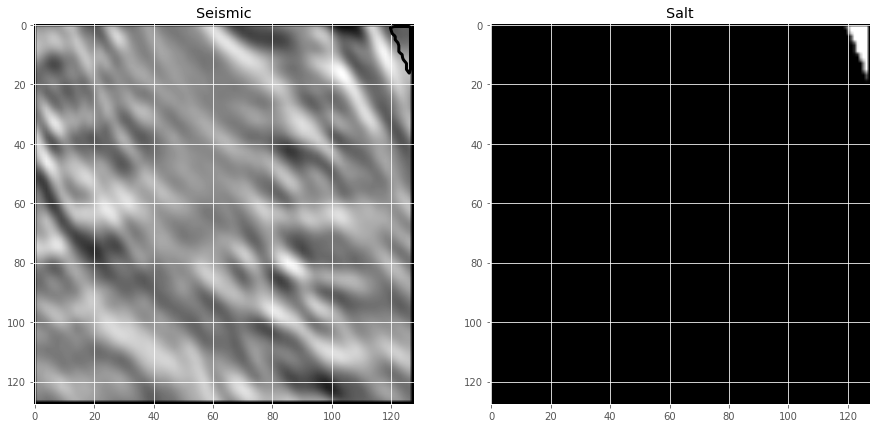

In [33]:
## Plotting Sample Data

def plot_sample_example():
    ix = random.randint(0, len(X_train))
    print(f"Random Sample Index is: {ix}")
    has_mask = y_train[ix].max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

    ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')

    ## If there is a mask
    if has_mask:
        ax1.contour(y_train[ix].squeeze(), colors = 'black', linewidths = 3, levels = [0.5])
    ax1.set_title('Seismic')

    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Salt')
    
plot_sample_example()


In [34]:
## 2D two Convolution layer block
def Conv2D_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers"""
    ## Convolution layer - 1
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
              kernel_initializer='he_normal', padding='same')(input_tensor)
    ## batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    ## Activation
    x = Activation('relu')(x)
        
    ## Convolution layer - 2
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
               kernel_initializer='he_normal', padding='same')(x)
    ## batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    ## Activation
    x = Activation('relu')(x)
    
    return x

In [35]:
## Unet Architecture
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=True):
    ## Encoder Path || Contractor Path
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)
    
    ## Decoder Path  || Expansion Path
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
   
    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
   
    ## final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [36]:

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [53]:
## Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 1), name='img')
model = unet(input_img, n_filters=16, kernel_size=3, dropout=0.05, batchnorm=True)
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])
model.compile(optimizer=Adam(), loss=jaccard_distance_loss, metrics=["accuracy"])

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [79]:
## Call Backs
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(WORK_DIR+'model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [56]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, \
                   validation_data=(X_valid, y_valid))

Epoch 1/50
55/56 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.6125
Epoch 1: val_loss improved from inf to 0.25092, saving model to model-tgs-salt.h5
56/56 [==============================] - 9s 113ms/step - loss: 0.3242 - accuracy: 0.6129 - val_loss: 0.2509 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 2/50
55/56 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.7025
Epoch 2: val_loss did not improve from 0.25092
56/56 [==============================] - 6s 102ms/step - loss: 0.2183 - accuracy: 0.7023 - val_loss: 0.3235 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 3/50
55/56 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.7091
Epoch 3: val_loss did not improve from 0.25092
56/56 [==============================] - 6s 103ms/step - loss: 0.1798 - accuracy: 0.7095 - val_loss: 0.6001 - val_accuracy: 0.1977 - lr: 0.0010
Epoch 4/50
55/56 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.7221
Epoch 4: ReduceL

In [57]:
model.save(WORK_DIR+'jac01.mod')
#model.save(WORK_DIR+'bce01.mod')

In [ ]:
model.load_weights(WORK_DIR+'jac01.mod')
# model.load_weights(WORK_DIR+'bce01.mod')

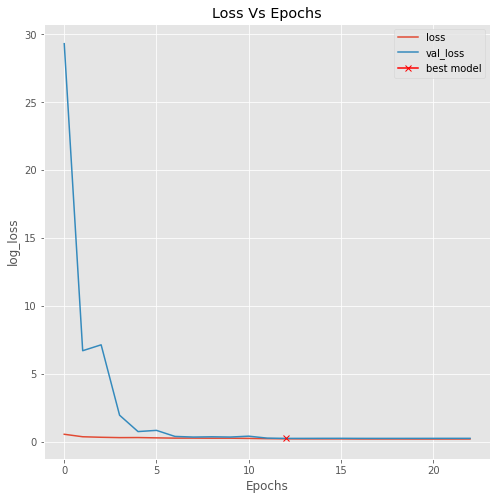

In [44]:
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

    
plot_history(results)

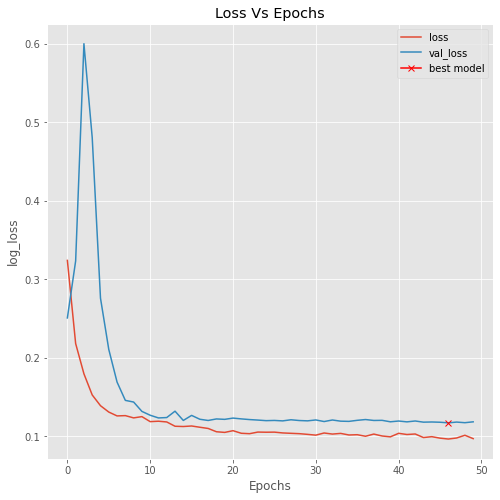

In [58]:
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

    
plot_history(results)

In [65]:
#Inference
model.load_weights('model-tgs-salt.h5')
model.evaluate(X_valid, y_valid, verbose=1)

7/7 [==============================] - 0s 36ms/step - loss: 0.1173 - accuracy: 0.7192


[0.11734702438116074, 0.7191866040229797]

In [66]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

7/7 [==============================] - 0s 24ms/step


In [67]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [48]:
def plot_sample_results(X, y, preds, binary_preds):
    ix = random.randint(0, len(X))
    
    has_mask = y[ix].max() > 0
    
    fig, ax = plt.subplots(1, 4, figsize=(20,10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')
    
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Salt Predicted Binary') ;

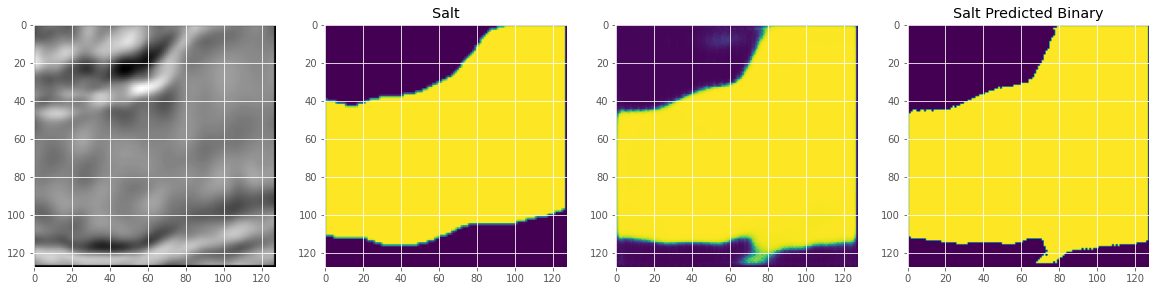

In [78]:
## Predictions on Training Set
plot_sample_results(X_train, y_train,preds_train,preds_train_t)

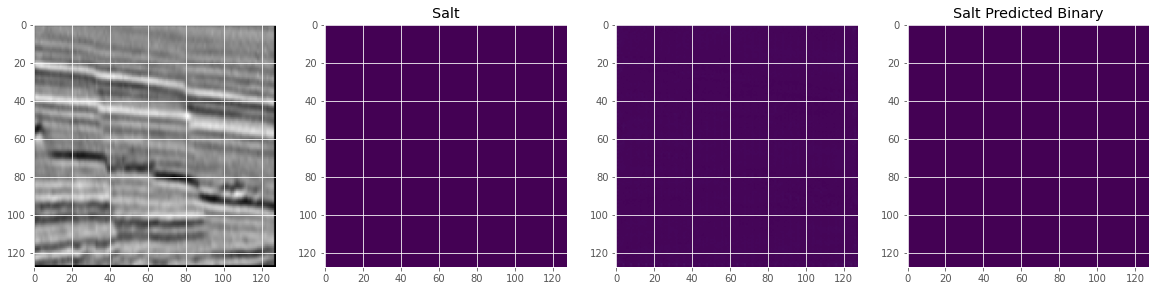

In [69]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

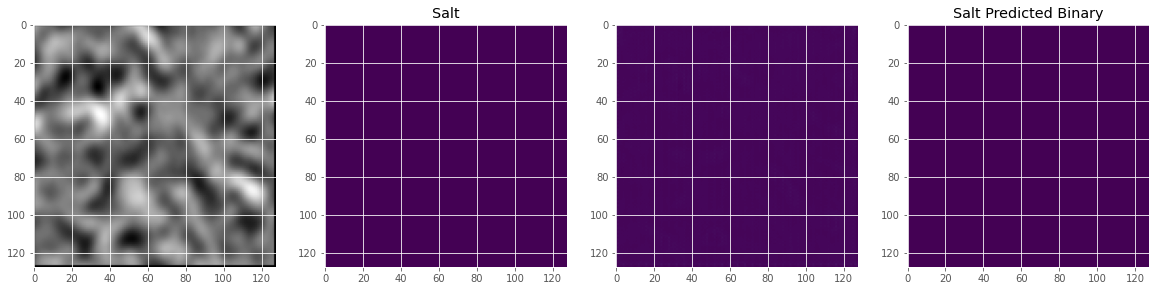

In [70]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

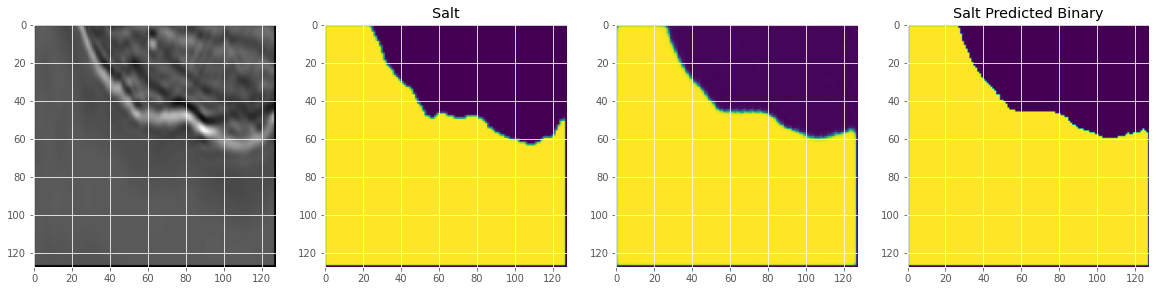

In [76]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)